# Rydberg calculations for $^{87}$Rb

 miscellaneous Rydberg calculations

References:
 * Minho's Thesis
 * Paul Huillery Thesis
 * Rydberg_atoms_a_primer_notebook (Pair Interaction)

In [1]:
from physconsts import *
from rbconsts import *
from numpy import *
from numpy.linalg import eigh
import matplotlib.pyplot as plt
import matplotlib as mpl
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
from time import time
from arc import *
from scipy.special import sph_harm as ylm

# local
from amophys import *

# other
mpl.rcParams.update(mpl.rcParamsDefault)

#### layout stuff
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

## Setup

In [2]:
# various setup
qq = ee**2/(4*pi*e0)

rb = Rubidium(87)

ldict = {0:'S',1:'P',2:'D',3:'F'} 
jdict = {.5:'1/2',1.5:'3/2',2.5:'5/2',3.5:'7/2'}

def hf_matrix_elem(F,mF,J,q,FF,mFF,JJ,I,RME=None):
    """ Returns the matrix element <F,mF,J|T_q|F',mF',J'>. 
    
        RME is the reduced matrix element (just a number), which can be calculated
        externally and passed in to be a multiplier. If RME=None, the 
        matrix element is in units of [RME].
        
        I is the nuclear spin of the atom.
    """

    rme = 1
    if RME!=None:
        rme = RME

    ## From Mark's notes, eqs. A-50,51
    mat_elem = rme*pow(-1,F+JJ+1+I)*sqrt((2*F+1)*(2*JJ+1)) \
                *wigner_6j(J,I,F,FF,1,JJ) \
                *clebsch_gordan(1,F,FF,q,mF,mFF)
    
    return mat_elem

## Misc Tests

LeRoy Radius
$R_{LR} = 2 \left( \sqrt{\langle r_1^2 \rangle} + \sqrt{\langle r_2^2 \rangle} \right) \approx 4 n^2 a_0 $

In [46]:
# Assumption of well-separated Rydberg atoms: atoms are separated by
# the LeRoy radius 

Rlr = lambda n,l: a0*sqrt(8*n**2*(5*n**2 + 1 - 3*l*(l+1)))

Rlr(87,2)

2.5326318795200154e-06

In [8]:
# what frequency needed for single-photon Rydberg excitation?

rb = Rubidium(87)
n1=5
l1=0
j1=1/2
mj1=1/2
n2=84
l2=1
j2=3/2
mj2=3/2
q=1
nuGHz = eVToGHz(rb.getEnergy(n2,l2,j2) - rb.getEnergy(n1,l1,j1))

In [15]:
c/(nuGHz*1e9)

2.969630820885388e-07

In [14]:
c/(c/(4.8e-7) + c/(7.8e-7))

2.9714285714285715e-07

In [4]:
help(rb.getEnergy)

Help on method getEnergy in module arc.alkali_atom_functions:

getEnergy(n, l, j, s=0.5) method of arc.alkali_atom_data.Rubidium instance
    Energy of the level relative to the ionisation level (in eV)
    
    Returned energies are with respect to the center of gravity of the
    hyperfine-split states.
    If `preferQuantumDefects` =False (set during initialization)
    program will try use NIST energy value, if such exists,
    falling back to energy calculation with quantum defects if
    the measured value doesn't exist. For `preferQuantumDefects` =True,
    program will always calculate energies from quantum defects
    (useful for comparing quantum defect calculations with measured
    energy level values).
    
    Args:
        n (int): principal quantum number
        l (int): orbital angular momentum
        j (float): total angular momentum
        s (float): optional, total spin angular momentum. Default value
            of 0.5 is correct for Alkali atoms, and has to be 

In [5]:
# Calculate oscillator strength between |87d_5/2> and nearby 
# states |n'l'J'> states. then calculate energy shifts from 
# forster resonances in pair states using only those states
# with some threshold level of oscillator strength

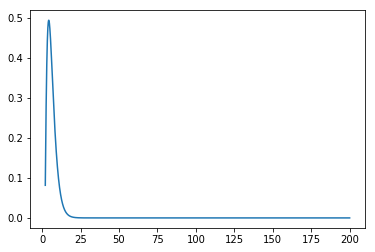

In [8]:
# TODO: try to make contour plots of the whole |psi|^2, i.e. including
# the angular part
s = 0.5
l = 0
j = 0.5
n = 5

rmin = rb.alphaC**(1/3)
rmax = 2*n*(n+15)

rpts, radial = rb.radialWavefunction(
    l,s,j,
    rb.getEnergy(n,l,j)/27.211, # don't know why 27.211 
    rmin,
    rmax,
    step=0.001
)

plt.plot(rpts, radial) 

## Dipole and Interaction Strengths

In [46]:
## single-photon ground-Rydberg coupling

rb.getDipoleMatrixElement(n1,l1,j1,mj1,n2,l2,j2,mj2,q)

rb = Rubidium(87)
n1=5
l1=0
j1=1/2
f1=2
mj1=1/2
mf1=0
n2=84
l2=1
j2=3/2
mj2=3/2
q=1
mq=1
nuGHz = eVToGHz(rb.getEnergy(n2,l2,j2) - rb.getEnergy(n1,l1,j1))
print("UV wavelength:",1e9*c/(nuGHz*1e9),"nm")
rabi = 2*pi*1e8 # desired Rabi rate
w0 = 6e-6
p = 0.5*c*e0*pi*w0**2*rabi/(rb.getDipoleMatrixElement(n1,l1,j1,mj1,n2,l2,j2,mj2,q)*ee*a0/hbar) #*clebsch_gordan(q,f1,j2,mq,mf1,mj2) # this CG is probably wrong.
print("power estimate:",p,"W")

UV wavelength: 296.96308208853884 nm
power estimate: 1.3786099322089828e-06 W


In [44]:
p

0

In [4]:
## dipole matrix elements between Rydberg states

n1 = 87
s = 0.5
l1 = 2
j1 = 2.5
mj1 = 2.5 # stretched state
q = -1 # lin-pol light

n2list = range(84,88)

ticklabels = []
matelems = []

for n2 in n2list:
    for l2 in [l1-1, l1+1]:
        for j2 in arange(l2-s,l2+s+1,1):
            if mj1 + q <= j2: 
                mj2 = mj1 + q
                matelems.append(
                    abs(rb.getDipoleMatrixElement(n1,l1,j1,mj1,n2,l2,j2,mj2,q))
                )
                ticklabels.append(f'|{n2}{ldict[l2]}_{jdict[j2]},{jdict[mj2]}>')

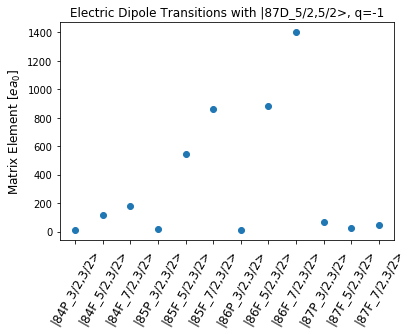

In [5]:
fig,ax = plt.subplots()

ax.scatter(range(len(matelems)),matelems)
ax.set_xticks(range(len(matelems)))
ax.set_xticklabels(ticklabels, rotation=60, fontsize='large')
ax.set_ylabel(r'Matrix Element [$e a_0$]', fontsize='large')
ax.set_title(f'Electric Dipole Transitions with |{n1}{ldict[l1]}_{jdict[j1]},{jdict[mj1]}>, q={q}')
plt.show()

## Two-Photon Rydberg Rabi Frequency

In [35]:
n1 = 5
l1 = 0
j1 = 1/2
mj1 = 1/2
n2 = 5
l2 = 1
j2 = 3/2
mj2 = 3/2
n3 = 84
l3 = 2
j3 = 5/2
mj3 = 5/2
q = 1

## red photon Rabi frequency... technically this should be between HF states, but it's close enough
redInt = (8e-6)/(pi*(6e-6)**2)
redRabi = sqrt(2*j1+1)*rb.getDipoleMatrixElement(n1,l1,j1,mj1,n2,l2,j2,mj2,q)*ee*a0*sqrt(redInt)/hbar
deltaRed = 2e9

## blue photon Rabi frequency
blueInt = 0.021/(pi*(4e-6)**2)
blueRabi = sqrt(2*j2+1)*rb.getDipoleMatrixElement(n2,l2,j2,mj2,n3,l3,j3,mj3,q)*ee*a0*sqrt(blueInt)/hbar
deltaBlue = -deltaRed

In [39]:
# blueRabi,redRabi

totalRabi = blueRabi*redRabi/(2*deltaRed)
print(totalRabi/1e6, "MHz")

0.5264676988507868 MHz


## Ionization

In [9]:
j3_from_j1j2(l1,1)

[1, 2, 3]

In [16]:
n1 = 84
l1 = 2
j1 = 5/2
for n2 in linspace(n1+100,n1+200,10):
    for l2 in [l1-1, l1+1]:
        for j2 in [j1-1, j1+1]:
            try:
                de = eVToGHz(rb.getEnergy(n2,l2,j2) - rb.getEnergy(n1,l1,j1)) 
                print(f'(n,l,j)f={[n2,l2,j2]}, energy={de} GHz')
            except:
                pass

(n,l,j)f=[184.0, 1, 1.5], energy=381.5354427445121 GHz
(n,l,j)f=[184.0, 3, 1.5], energy=384.36939009845787 GHz
(n,l,j)f=[184.0, 3, 3.5], energy=384.36939009845787 GHz
(n,l,j)f=[195.11111111111111, 1, 1.5], energy=392.7505343843338 GHz
(n,l,j)f=[195.11111111111111, 3, 1.5], energy=395.12438995085915 GHz
(n,l,j)f=[195.11111111111111, 3, 3.5], energy=395.12438995085915 GHz
(n,l,j)f=[206.22222222222223, 1, 1.5], energy=402.1799265506877 GHz
(n,l,j)f=[206.22222222222223, 3, 1.5], energy=404.1881319772846 GHz
(n,l,j)f=[206.22222222222223, 3, 3.5], energy=404.1881319772846 GHz
(n,l,j)f=[217.33333333333331, 1, 1.5], energy=410.18353621481134 GHz
(n,l,j)f=[217.33333333333331, 3, 1.5], energy=411.8974925716004 GHz
(n,l,j)f=[217.33333333333331, 3, 3.5], energy=411.8974925716004 GHz
(n,l,j)f=[228.44444444444446, 1, 1.5], energy=417.03496785992644 GHz
(n,l,j)f=[228.44444444444446, 3, 1.5], energy=418.5094649488035 GHz
(n,l,j)f=[228.44444444444446, 3, 3.5], energy=418.5094649488035 GHz
(n,l,j)f=[239

## Dipole-Dipole Interactions

In [7]:
def V_dd(a1,b1,a2,b2,r12,atom):
    """
    dipole-dipole matrix elem including fine structure
    a1,b1,a2,b2 are each lists of form [n,l,j,mj] denoting the states 1 and 2 of atoms a,b
    r12 is atom separation
    atom is a PairInteraction atom object
    
    Default units are S.I., so Joules
    """
    na1,la1,ja1,ma1 = a1
    nb1,lb1,jb1,mb1 = b1
    na2,la2,ja2,ma2 = a2
    nb2,lb2,jb2,mb2 = b2
    
    q=0 # dipole has linear polarization
    matelem = 0

    for p in [-1,0,1]:V
        try:
            matelem += clebsch_gordan(1,1,2,p,-p,q)* \
                atom.getDipoleMatrixElement(na1,la1,ja1,ma1,na2,la2,ja2,ma2,p)* \
                atom.getDipoleMatrixElement(nb1,lb1,jb1,mb1,nb2,lb2,jb2,mb2,-p)
        except ValueError:
            pass # CG coefficient is zero; ignore.
    
    matelem *= -qq**2*sqrt(6)/r12
    return matelem

In [8]:
# initial pair state, ignoring Zeeman substates
na1 = 43
la1 = 2
ja1 = 5/2

nb1 = 43
lb1 = 2
jb1 = 5/2
# final pair state, """
na2 = 45
la2 = 1
ja2 = 3/2

nb2 = 41
lb2 = 3
jb2 = 7/2

delta = -(rb.getEnergy(na1,la1,ja1) 
         + rb.getEnergy(nb1,lb1,jb1)
         - rb.getEnergy(na2,la2,ja2)
         - rb.getEnergy(nb2,lb2,jb2))*ee/(2*pi*hbar*10**6)
print(f"Forster defect = {delta} [MHz]")

# initial state with possible projections
basis_i = [[[na1, la1, ja1, ma],[nb1, lb1, jb1, mb]] for ma in arange(-ja1, ja1+1,1) for mb in arange(-jb1, jb1+1,1)]
# final state with possible projections
basis_f = [[[na2, la2, ja2, ma],[nb2, lb2, jb2, mb]] for ma in arange(-ja2, ja2+1,1) for mb in arange(-jb2, jb2+1,1)]

basis = basis_i + basis_f
dim = len(basis)
print(f"number of basis pair states: {dim}")

Forster defect = -8.334369904025891 [MHz]
number of basis pair states: 68


In [ ]:
basis_i = [[[na1, la1, ja1, ma],[nb1, lb1, jb1, mb]] for ma in arange(-ja1, ja1+1,1) for mb in arange(-jb1, jb1+1,1) if mb+ma==]


In [60]:
## build and diagonalize the full hamiltonian. Units MHz. 

# eigenvector arrays are stored in the convention of numpy's eigh: 
# a 2D array whose columns are the e-vectors 

# things to add -- include diamagnetic interaction

# Note that is an overkill approach to solving the 43-43 -> 41-45 example,
# but is robust for handling more complicated systems later where level
# crossings are involved, i.e. spaghetti

t0 = time()
H_atom = zeros((dim,dim))
for i in range(dim - int((2*ja2+1)*(2*jb2+1)),dim):
    H_atom[i,i] = delta
    
# the original evecs:
ovecs = identity(dim)

numsteps = 4
solution = empty((dim,numsteps)) # numrows = len(basis), numcols = numsteps 

rsteps = linspace(20e-5,19.5e-5,numsteps)
for sol_idx, r12 in enumerate(rsteps): # separation between atoms 1,2 

    # compute H_vdd
    H_vdd = zeros((dim,dim))
    for i,pairstate_i in enumerate(basis):
        for j,pairstate_j in enumerate(basis):
            state_ai,state_bi = pairstate_i
            state_aj,state_bj = pairstate_j
            H_vdd[i,j] = V_dd(state_ai,state_bi,state_aj,state_bj,r12,rb)/(2*pi*hbar*10**6)

    # diagonalize the full Hamiltonian
    H_full = H_atom + H_vdd
    evals,evecs = eigh(H_full)    
    
    # sort the eigenvalues so they "match up" with the energies at the previous step
    # by taking measuring the overlap of the new evecs with the old ones
    evals_sorted = empty(dim)
    evecs_sorted = empty((dim,dim))
    for i in range(dim):
        # get index of evec that maximally overlaps old evec i
        idx = 0
        maxval = 0
        for j in range(dim):
            overlap = vdot(evecs[:,i],ovecs[:,j])
            if overlap > maxval:
                maxval = overlap
                idx = j
        evals_sorted[i] = evals[idx]
        evecs_sorted[:,i] = evecs[:,idx]
    
    # redefine old eigenvectors
    ovecs = evecs_sorted
    
    # insert e-values in solution as a column
    solution[:,sol_idx] = evals_sorted
    
# insert the unperturbed energy levels (i.e. at r12 = infty) last:
# solution[:,-1]  = array([H_atom[i,i] for i in range(dim)])

print(f"computed evecs solution in {time()-t0} [s]")

computed evecs solution in 93.51566863059998 [s]


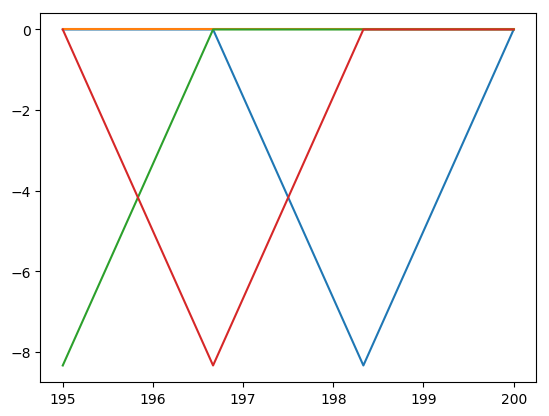

In [61]:
fig,ax = plt.subplots()
for i in range(numsteps):
    ax.plot(rsteps/1e-6,solution[i])
# ax.plot(rsteps/1e-6,solution[0])

In [165]:
## sort the new evals by overlap of evecs with old evecs

evals_sorted = empty(dim)

ovecs = identity(dim)
# for i in range(dim):
#     evals_sorted.append(max([vdot(evecs[:,i],ovecs[:,j]) for j in range(dim)]))

for i in range(dim):
    # get index of evec that maximally overlaps old evec i
    idx = 0
    maxval = 0
    for j in range(dim):
        overlap = vdot(evecs[:,i],ovecs[:,j])
        if overlap > maxval:
            maxval = overlap
            idx = j
    evals_sorted[i] = evals[idx]
        
    # get eigenvalue at j

# vvecs = array([v*evecs[:,i] for i,v in enumerate(evals)]) # the current e-energies times resp. e-vectors
# old_vvecs = array([H_full[i,i]*array(vec) for i,vec in enumerate(identity(dim))]) #  # the old e-energies times resp. e-vectors

In [166]:
evals_sorted

array([-1.50361402e-15, -8.33436990e+00, -1.84610795e-15,  1.04411494e-15,
        5.41828635e-15,  5.82500576e-16, -6.77083357e-16, -1.84610795e-15,
       -1.38795140e-15, -1.50361402e-15, -1.33106320e-15,  1.15662617e-15,
       -1.71034868e-15, -1.50361402e-15,  1.12176134e-15,  2.87182188e-15,
       -8.33436990e+00,  1.04411494e-15,  1.79556333e-15,  2.06099999e-15,
       -9.95680270e-16, -3.92271135e-16,  1.85060187e-15, -2.25431818e-16,
        1.68568424e-15,  2.33243805e-15, -2.12914095e-16,  2.87182188e-15,
        2.87182188e-15,  1.68568424e-15,  1.79556333e-15,  1.12176134e-15,
       -8.33436990e+00, -8.33436990e+00, -8.33436990e+00, -8.33436990e+00,
       -8.33436990e+00, -8.33436990e+00, -8.33436990e+00, -8.33436990e+00,
       -8.33436990e+00, -2.94625880e-15, -8.33436990e+00, -8.33436990e+00,
       -8.33436990e+00, -8.33436990e+00, -8.33436990e+00, -8.33436990e+00,
       -2.60435208e-15, -8.33436990e+00, -8.33436990e+00, -8.33436990e+00,
       -8.33436990e+00, -

In [155]:
# vdot(vvecs[2], old_vvecs[2])
# vvecs.shape, old_vvecs.shape

0.0

In [157]:
for i in range(dim):
    evals_sorted.append(max([vdot(vvec, old_vvec) for vvec,old_vvec in zip(vvecs,old_vvecs)]))

In [29]:
log10(ee/(2*pi*hbar)) # this says 1 eV is about 100 THz, so E ~ a few eV has an optical wavelength

14.383454371569494